In [1]:
using Evolutionary
using Flux
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using MLDatasets
using Random

In [2]:
using ZipFile, CSV, DataFrames, Random, StatsBase , Plots, Statistics

# read file from zip archive

z = ZipFile.Reader("results.zip")

# identify the right file in zip

# The diabetes dataset I found through kaggle have done split into 2 classifiers and select 50 percents of result from each 
# label. So i think there is more work in my dataset

a_file_in_zip = filter(x->x.name == "diabetes_binary_5050split_health_indicators_BRFSS2015.csv", z.files)[1]

#avoid changing the original files in the zip file. However, the dataset will not change but whatever.

a_copy = CSV.File(a_file_in_zip) |> DataFrame

close(z)

#show the dataset

a_copy

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,1.0,1.0,25.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,29.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,26.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,36.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,26.0,1.0,0.0,0.0
9,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0


In [3]:
# Transfer DataFrame to matrix form

df=a_copy|>Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

df_0 = df[df[:,1] .== 0, :]
df_1 = df[df[:,1] .== 1, :]

35346×22 Matrix{Float64}:
 1.0  1.0  1.0  1.0  30.0  1.0  0.0  1.0  …  30.0  1.0  0.0   9.0  5.0  1.0
 1.0  0.0  0.0  1.0  25.0  1.0  0.0  0.0      0.0  0.0  1.0  13.0  6.0  8.0
 1.0  1.0  1.0  1.0  28.0  0.0  0.0  0.0      0.0  1.0  0.0  11.0  4.0  6.0
 1.0  0.0  0.0  1.0  23.0  1.0  0.0  0.0      0.0  0.0  1.0   7.0  5.0  6.0
 1.0  1.0  0.0  1.0  27.0  0.0  0.0  0.0      0.0  0.0  0.0  13.0  5.0  4.0
 1.0  1.0  1.0  1.0  37.0  1.0  1.0  1.0  …   0.0  1.0  1.0  10.0  6.0  5.0
 1.0  1.0  1.0  1.0  28.0  1.0  0.0  1.0      0.0  0.0  1.0  12.0  2.0  4.0
 1.0  1.0  1.0  1.0  27.0  1.0  0.0  0.0     20.0  1.0  0.0   8.0  4.0  7.0
 1.0  1.0  1.0  1.0  34.0  1.0  1.0  0.0      7.0  1.0  0.0   9.0  5.0  4.0
 1.0  1.0  1.0  1.0  24.0  1.0  0.0  0.0      0.0  0.0  0.0  12.0  3.0  3.0
 1.0  1.0  0.0  1.0  31.0  0.0  0.0  0.0  …   5.0  0.0  0.0  13.0  4.0  4.0
 1.0  1.0  1.0  1.0  33.0  1.0  0.0  0.0     30.0  1.0  0.0  11.0  4.0  2.0
 1.0  1.0  1.0  1.0  27.0  1.0  0.0  0.0     30.0  1.0  0.0  1

In [4]:
# The columns of matrix is 35346(here just using 35000 is the same), using random sub-sequence to select 70 percents of 
# columns as the train data.

sample = randsubseq(1:35000, 0.7)
train_df = vcat(df_0[sample, :], df_1[sample, :])

# Then from the not selected columns (which is 30 percents) to select the test data.

notsample = [i for i in 1:35000 if isempty(searchsorted(sample, i))]
test_df = vcat(df_0[notsample, :], df_1[notsample, :])

20570×22 Matrix{Float64}:
 0.0  0.0  0.0  0.0  24.0  0.0  0.0  0.0  …   0.0  0.0  1.0   7.0  5.0  8.0
 0.0  1.0  1.0  1.0  36.0  0.0  0.0  0.0      2.0  0.0  1.0  11.0  6.0  8.0
 0.0  0.0  0.0  1.0  21.0  0.0  0.0  0.0      0.0  0.0  0.0   8.0  5.0  6.0
 0.0  1.0  1.0  1.0  23.0  1.0  0.0  1.0      0.0  0.0  0.0   6.0  4.0  6.0
 0.0  1.0  1.0  1.0  31.0  1.0  0.0  0.0      0.0  0.0  1.0   8.0  4.0  8.0
 0.0  0.0  0.0  1.0  35.0  0.0  0.0  0.0  …   0.0  0.0  1.0   7.0  4.0  7.0
 0.0  0.0  0.0  1.0  37.0  1.0  0.0  0.0      0.0  0.0  0.0   5.0  6.0  6.0
 0.0  0.0  0.0  1.0  23.0  0.0  0.0  0.0      3.0  0.0  0.0   2.0  5.0  8.0
 0.0  0.0  0.0  1.0  25.0  0.0  0.0  0.0      3.0  0.0  1.0   4.0  6.0  8.0
 0.0  1.0  1.0  1.0  24.0  0.0  0.0  0.0     20.0  0.0  1.0  13.0  6.0  6.0
 0.0  0.0  0.0  1.0  26.0  1.0  0.0  0.0  …   0.0  0.0  0.0   5.0  6.0  8.0
 0.0  1.0  0.0  1.0  22.0  1.0  0.0  0.0      0.0  0.0  0.0  11.0  5.0  7.0
 0.0  0.0  0.0  1.0  30.0  1.0  0.0  0.0      4.0  0.0  1.0   

In [5]:
# Divide the columns into features and result. From my dataset, From 2 to 22 columns are the attributes of whether diabetes or not.

X_train = train_df[:, 2:22]
X_test = test_df[:, 2:22]

y_train = train_df[:, 1]
y_test = test_df[:, 1]

20570-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [6]:
using Distributions

# Transfer the X_train to 1 diminension.

dt = fit(ZScoreTransform, X_train, dims=1)

# Using StateBase package to transfer X_train and X_test(make them standard) to the same formate as dt.

X_train_std = StatsBase.transform(dt, X_train)
X_test_std = StatsBase.transform(dt, X_test)

# Transpose the X_train_std and X_test_std.
    
X_train_std, X_test_std= transpose(X_train_std), transpose(X_test_std)

([-1.1457331532225008 -1.1457331532225008 … 0.8727859245045625 0.8727859245045625; 0.9493971771738328 -1.053278641872066 … -1.053278641872066 0.9493971771738328; … ; 0.07122984250716069 1.0441204518271212 … 1.0441204518271212 -0.9016607668127998; 0.5959338525728632 1.0576786653744406 … -1.7127902114350237 -2.1745350242366013], [-1.1457331532225008 0.8727859245045625 … 0.8727859245045625 0.8727859245045625; -1.053278641872066 0.9493971771738328 … -1.053278641872066 -1.053278641872066; … ; 0.07122984250716069 1.0441204518271212 … -1.8745513761327606 -0.9016607668127998; 1.0576786653744406 1.0576786653744406 … -0.789300585831869 -0.789300585831869])

In [7]:
train_data=zip(X_train_std,y_train)
test_data=zip(X_test_std,y_test)

zip([-1.1457331532225008 0.8727859245045625 … 0.8727859245045625 0.8727859245045625; -1.053278641872066 0.9493971771738328 … -1.053278641872066 -1.053278641872066; … ; 0.07122984250716069 1.0441204518271212 … -1.8745513761327606 -0.9016607668127998; 1.0576786653744406 1.0576786653744406 … -0.789300585831869 -0.789300585831869], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [8]:
#Create model list,each model represents an individual in population
function model_population(size)
    population = []
    for i in 1:size
        smodel = sigmoidmodel(Batch_size)
        append!(population,[smodel])
    end
    return population
end

model_population (generic function with 1 method)

In [9]:
# #train models and get the accuracy list,sort them by accuracy
# function train_models(model_list)
#     model_mean_acc_list = []
#     for model in model_list
#         model_acc_list = []
#         for (x,y) in train_data
#             pred = model(x)
#             ac = acc(pred,y)
#             append!(model_acc_list,ac)
#         end
#         append!(model_mean_acc_list,mean(model_acc_list))
#     end
    
#     index=reverse(sortperm(model_mean_acc_list))
#     model_mean_acc_list=model_mean_acc_list[index]
#     model_list=model_list[index]
    
#     return model_list,model_mean_acc_list
# end

In [10]:
#train models and get the accuracy list,sort them by accuracy
function train_models(model_list)
    model_mean_acc_list = []
    i=1
    for model in model_list
        append!(model_mean_acc_list,mean(accuracy(X_train_std,y_train,i)))
        i=i+1
    end
    
    index=reverse(sortperm(model_mean_acc_list))
    model_mean_acc_list=model_mean_acc_list[index]
    model_list=model_list[index]
    
    return model_list,model_mean_acc_list
end

train_models (generic function with 1 method)

In [11]:
function test_model(model)
    model_acc_list=[]
    return mean(accuracy(X_test_std,y_test))
end

test_model (generic function with 1 method)

In [12]:
# function test_model(model)
#     model_acc_list=[]
#     for (x,y) in test_data
#         pred=model(x)
#         sacc=acc(x,y)
#         push!(model_acc_list,sacc)
#     end
#     return mean(model_acc_list)
# end

In [13]:
#Do Crossover here 
function crossover(father,mother)
    nn=deepcopy(father)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        mother_bias=mother[select_one_layer].bias
        picked_one_row=shuffle(collect(1:size(mother_bias)[1]))[1]
        if rand() < Crossover_rate
            nn[select_one_layer].bias[picked_one_row]=mother_bias[picked_one_row]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        mother_weight=nn[select_one_layer].weight
        picked_one_row=shuffle(collect(1:size(mother_weight)[1]))[1]
        picked_one_col=shuffle(collect(1:size(mother_weight)[2]))[1]
        if rand() < Crossover_rate
            nn[select_one_layer].weight[picked_one_row,picked_one_col]=mother_weight[picked_one_row,picked_one_col]
        end
    end
    return nn
end

crossover (generic function with 1 method)

In [ ]:
#Do Crossover here 
function crossover(father,mother)
    nn=deepcopy(father)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        mother_bias=mother[select_one_layer].bias
        picked_one_row=shuffle(collect(1:size(mother_bias)[1]))[1]
        if rand() < Crossover_rate
            nn[select_one_layer].bias[picked_one_row]=mother_bias[picked_one_row]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        mother_weight=nn[select_one_layer].weight
        picked_one_row=shuffle(collect(1:size(mother_weight)[1]))[1]
        picked_one_col=shuffle(collect(1:size(mother_weight)[2]))[1]
        if rand() < Crossover_rate
            nn[select_one_layer].weight[picked_one_row,picked_one_col]=mother_weight[picked_one_row,picked_one_col]
        end
    end
    return nn
end

In [14]:
#Do mutation here
function mutation(new_child)
    nn=deepcopy(new_child)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        bias=new_child[select_one_layer].bias
        picked_one_row=shuffle(collect(1:size(bias)[1]))[1]
        if rand() < Mutation_rate
            nn[select_one_layer].bias[picked_one_row]+=rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        weight=nn[select_one_layer].weight
        picked_one_row=shuffle(collect(1:size(weight)[1]))[1]
        picked_one_col=shuffle(collect(1:size(weight)[2]))[1]
        if rand() < Mutation_rate
            nn[select_one_layer].weight[picked_one_row,picked_one_col]+=rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    return nn
end

mutation (generic function with 1 method)

In [ ]:
#Do mutation here
function mutation(new_child)
    nn=deepcopy(new_child)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        bias=new_child[select_one_layer].bias
        picked_one_row=shuffle(collect(1:size(bias)[1]))[1]
        if rand() < Mutation_rate
            nn[select_one_layer].bias[picked_one_row]+=rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        weight=nn[select_one_layer].weight
        picked_one_row=shuffle(collect(1:size(weight)[1]))[1]
        picked_one_col=shuffle(collect(1:size(weight)[2]))[1]
        if rand() < Mutation_rate
            nn[select_one_layer].weight[picked_one_row,picked_one_col]+=rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    return nn
end

In [15]:
#parameters:
Batch_size = 21
Pop_size = 300
Mutation_rate = 0.5
Crossover_rate = 0.4
Retain_rate = 0.4
iteration = 30
layer = 2

2

In [16]:
#build the model using sigmoid as Activation Function
#The input dim is 12 as 12 features and the output dim is 2 represent A and B
function sigmoidmodel(input_dim)
    model = Chain(Dense(21, 8, sigmoid), Dense(8, 1, sigmoid))
    return model
end

sigmoidmodel (generic function with 1 method)

In [17]:
base_model=Chain(Dense(21, 8, sigmoid), Dense(8, 1, sigmoid))

Chain(
  Dense(21, 8, σ),                      # 176 parameters
  Dense(8, 1, σ),                       # 9 parameters
)                   # Total: 4 arrays, 185 parameters, 996 bytes.

In [37]:
#Get Model List
model_list = model_population(Pop_size)

300-element Vector{Any}:
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 ⋮
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 1

In [29]:
using BSON: @load
using Zygote 
using Flux

@load string("mymode_",(1),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(2),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(3),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(4),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(5),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(6),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(7),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(8),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(9),".bson") base_model
push!(model_list,base_model)
@load string("mymode_",(10),".bson") base_model
push!(model_list,base_model)

20-element Vector{Any}:
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 p

In [20]:
train_acc_list = []
test_acc_list = []

Any[]

In [35]:
model_list

12-element Vector{Any}:
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters
 Chain(Dense(21, 8, σ), Dense(8, 1, σ))  # 185 parameters

In [38]:
using Flux
using Flux: logitbinarycrossentropy
using BSON: @save

accuracy(x, y) = mean(vec(model_list[1](x) .> 0.5) .== y)
accuracy(x, y, i) = mean(vec(model_list[i](x) .> 0.5) .== y)
model,score = train_models(model_list)
#erase models with low accuracy
model_list = model_list[1:Int(size(model_list)[1]*Retain_rate)]
test_acc=test_model(model_list[1])

append!(train_acc_list,score[1])
append!(test_acc_list,test_acc)

println("\nTrial") 
for i in 1:30
    println(accuracy(X_train_std, y_train,i))
end
while size(model_list)[1]<Pop_size
    #pick up object to do crossover
    model_mean_acc_list = []
    i=1
    for model in model_list
        append!(model_mean_acc_list,mean(accuracy(X_train_std,y_train,i)))
        i=i+1
    end

    index=reverse(sortperm(model_mean_acc_list))
    model_mean_acc_list=model_mean_acc_list[index]
    model_list=model_list[index]
    idx=collect(1:size(model_list)[1])
    idx=shuffle(idx)
    father=model_list[idx[1]]
    mother=model_list[idx[2]]

    new_child=crossover(father,mother)
    new_child=mutation(new_child)
    append!(model_list,[new_child])
end
println("new")
for j in 1:30
    println(accuracy(X_train_std, y_train,j))
end



Trial
0.5460246813675905
0.5989884685413717
0.5345741452559175
0.49755209387011934
0.5467732146469755
0.4742464090633219
0.49609548856969454
0.6092656281610358
0.5357272911187538
0.574711713534291
0.4428484725874975
0.5033178231843011
0.5128059882662351
0.4918875177018005
0.44659113898442243
0.4873356261379729
0.44626744891766135
0.496682176815699
0.5769370827432733
0.5
0.5
0.5197450940724256
0.5000202306291726
0.5292130285251871
0.5049160428889339
0.4934452761480882
0.5742464090633219
0.4540764717782723
0.5
0.5
new
0.6602265830467328
0.6445276148088206
0.6408254096702407
0.6268865061703419
0.6256524377908153
0.6250657495448109
0.624216063119563
0.6222739227189965
0.6133522152538944
0.6132510621080316
0.611733764920089
0.60977139389035
0.6092656281610358
0.609164475015173
0.6041675096095489
0.6034392069593364
0.6024479061298806
0.6019016791422214
0.5989884685413717
0.5989884685413717
0.5973700182075663
0.5953064940319643
0.5942342706858184
0.5924337446894599
0.589338458426057
0.583087

In [39]:
test=[]
for j in 1:30
    push!(test,accuracy(X_train_std, y_train,j))
end

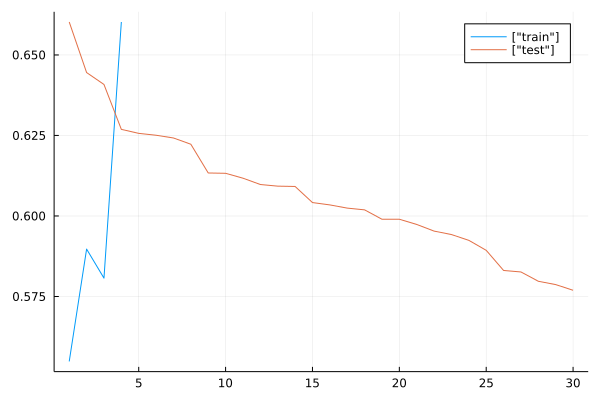

In [43]:
Plots.plot(train_acc_list,label=["train"])
Plots.plot!(test,label=["test"])

In [25]:
"""
    In order to compute for confusion matrix
"""
#TT
TT=sum(vec(model_list[1](X_test_std) .> 0.5) .== 1)
#TF
TF=sum(vec(model_list[1](X_test_std) .> 0.5) .== 0)
#FT
FT=sum(vec(model_list[1](X_test_std) .< 0.5) .== 1)
#FF
FF=sum(vec(model_list[1](X_test_std) .< 0.5) .== 0)
println("confusion matrix of test data in best model:")
println("true_true_result->$TT,  true_false_result->$TF")
println("false_false_result->$FF,   false_true_result->FT")

confusion matrix of test data in best model:
true_true_result->5422,  true_false_result->15148
false_false_result->5422,   false_true_result->FT
